In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#### Defining the problem (classical form)

$$\text{Minimize } Z = x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8$$

$\text{Subject to}$

$x_1 + x_2 \geq 1$

$x_2 + x_3 \geq 1$

$x_4 + x_5 \geq 1$

$x_7 + x_8 \geq 1$

$x_6 + x_7 \geq 1$

$x_2 + x_6 \geq 1$

$x_1 + x_6 \geq 1$

$x_4 + x_7 \geq 1$

$x_2 + x_4 \geq 1$

$x_5 + x_8 \geq 1$

$x_3 + x_5 \geq 1$

#### Transforming the problem to QUBO

This is a equivalent form of the problem, passing the constraints as penalty terms(P) in the objective function to be minimized

$$
\min_{x \in \{0,1\}^n} \mu^T x + P
$$

Where P is defined as:

$$
P = \alpha \sum_{(i,j)}[1 - x_i - x_j + x_{i}x_j] + \beta \sum_{(i,j)}x_{i}x_j
$$

Here, $\alpha$ is the wheight of the penalty for violating the constraints, and $\beta$ is the weight of the penalty for over-satisfying the constraints

which is equivalent to

$$
\min_{x \in \{0,1\}^n} \sum_{i}x_i + \alpha \sum_{(i,j)}[1 - x_i - x_j + x_{i}x_j] + \beta \sum_{(i,j)}x_{i}x_j
$$

In [87]:
# Initialize Quadratic Program
mod = QuadraticProgram("maximum coverage problem")

# Define binary variables
for i in range(8):
    mod.binary_var(name="x" + str(i + 1))

# Define the linear term for the objective
lin = np.ones(8)
quad = np.zeros((8, 8))

# Add the original objective: Minimize the sum of x_i
mod.minimize(constant=0, linear=lin, quadratic=quad)

# Adjust penalty weights
alpha = 10000000  # High penalty for violations (x_i + x_j < 1)

penalties = [
    ("x1", "x2"),
    ("x2", "x3"),
    ("x4", "x5"),
    ("x7", "x8"),
    ("x6", "x7"),
    ("x2", "x6"),
    ("x1", "x6"),
    ("x4", "x7"),
    ("x2", "x4"),
    ("x5", "x8"),
    ("x3", "x5"),
]

for var1, var2 in penalties:
    # Penalty for under-satisfaction: alpha * (1 - x_i - x_j)^2
    mod.objective.constant += alpha  # Constant term (from 1)
    mod.objective.linear[var1] += -alpha  # Linear term for x_i
    mod.objective.linear[var2] += -alpha  # Linear term for x_j
    mod.objective.quadratic[var1, var2] += alpha  # Quadratic term for x_i * x_j

# Display the problem
print(mod.prettyprint())

Problem name: maximum coverage problem

Minimize
  10000000*x1*x2 + 10000000*x1*x6 + 10000000*x2*x3 + 10000000*x2*x4
  + 10000000*x2*x6 + 10000000*x3*x5 + 10000000*x4*x5 + 10000000*x4*x7
  + 10000000*x5*x8 + 10000000*x6*x7 + 10000000*x7*x8 - 19999999*x1 - 39999999*x2
  - 19999999*x3 - 29999999*x4 - 29999999*x5 - 29999999*x6 - 29999999*x7
  - 19999999*x8 + 110000000

Subject to
  No constraints

  Binary variables (8)
    x1 x2 x3 x4 x5 x6 x7 x8



In [88]:
penalty_value = 1
qubo_problem = QuadraticProgramToQubo(penalty=penalty_value).convert(mod)

In [89]:
print(qubo_problem.prettyprint())

Problem name: maximum coverage problem

Minimize
  10000000*x1*x2 + 10000000*x1*x6 + 10000000*x2*x3 + 10000000*x2*x4
  + 10000000*x2*x6 + 10000000*x3*x5 + 10000000*x4*x5 + 10000000*x4*x7
  + 10000000*x5*x8 + 10000000*x6*x7 + 10000000*x7*x8 - 19999999*x1 - 39999999*x2
  - 19999999*x3 - 29999999*x4 - 29999999*x5 - 29999999*x6 - 29999999*x7
  - 19999999*x8 + 110000000

Subject to
  No constraints

  Binary variables (8)
    x1 x2 x3 x4 x5 x6 x7 x8



In [77]:
hamiltonian, offset = qubo_problem.to_ising()

In [78]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [79]:
def run_experiment(n_range, p, shots_estimator, shots_sampler, level):
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=level)

    ansatz = QAOAAnsatz(hamiltonian, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    
    results_x = []
    for i in range(n_range):
        x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")
    results_x_mean = np.mean(results_x, axis=0)

    qc = ansatz.assign_parameters(results_x_mean)
    qc.measure_all()
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa]).result()
    samp_dist = result[0].data.meas.get_counts()

    # Sort the states by their probabilities
    sorted_samp_dist = sorted(samp_dist.items(), key=lambda item: item[1], reverse=True)

    # Extract the top 20 most probable states
    top_20_states = sorted_samp_dist[:20]

    # Calculate probabilities
    total_samples = sum(samp_dist.values())
    top_states = [state for state, _ in top_20_states]
    top_probabilities = [count / total_samples for _, count in top_20_states]

    # Plot a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(top_states, top_probabilities, color="skyblue")
    plt.xlabel("Quantum States")
    plt.ylabel("Probability")
    plt.title("Top 20 Most Probable States")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

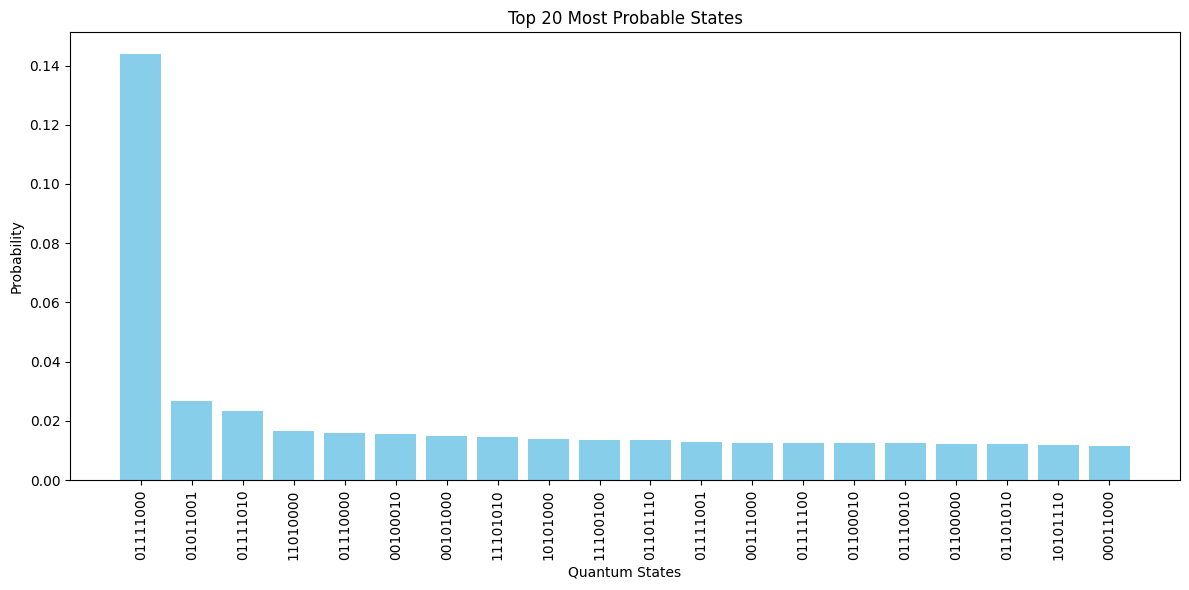

In [96]:
run_experiment(10, 2, 5000, 5000, 1)

Estimator shots:  10000 
Samplere shots:  10000


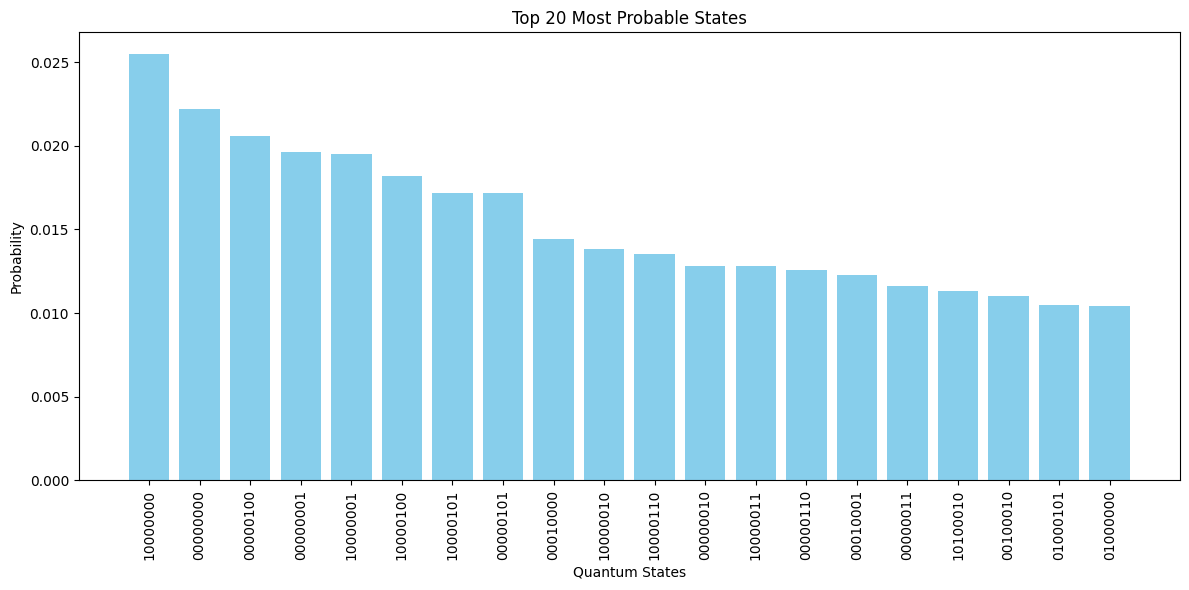

Estimator shots:  10000 
Samplere shots:  20000


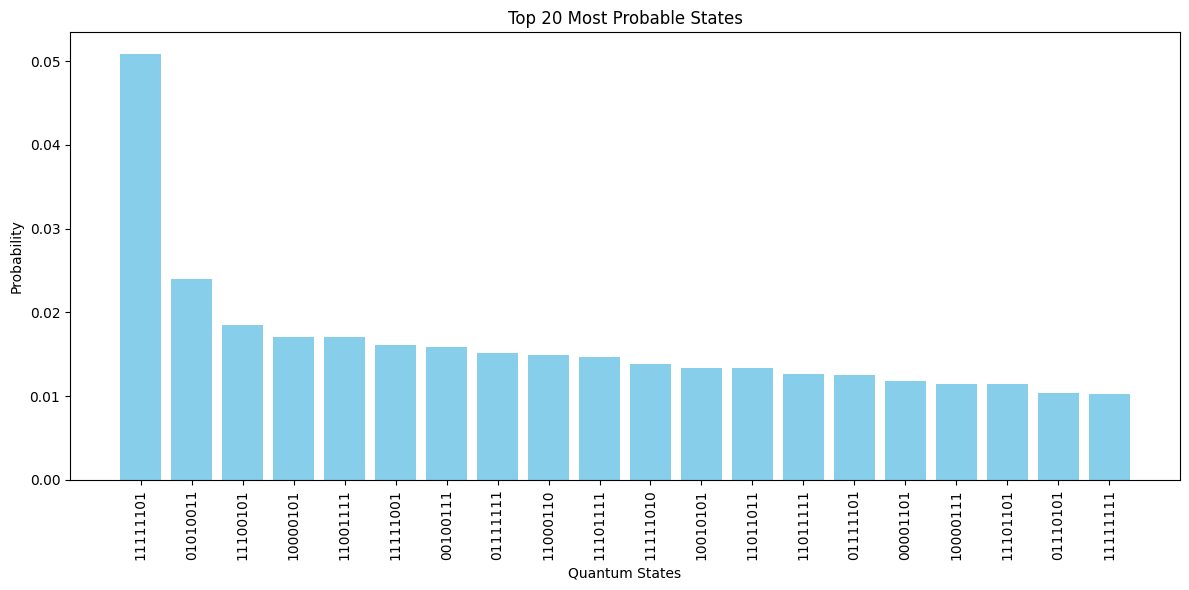

Estimator shots:  10000 
Samplere shots:  30000


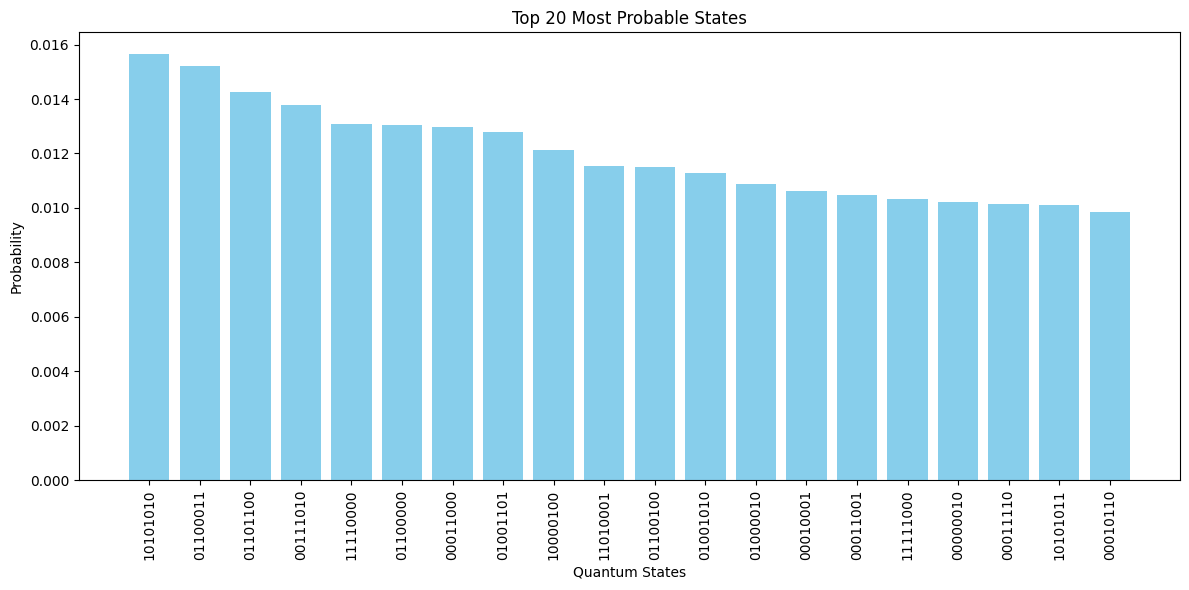

Estimator shots:  10000 
Samplere shots:  40000


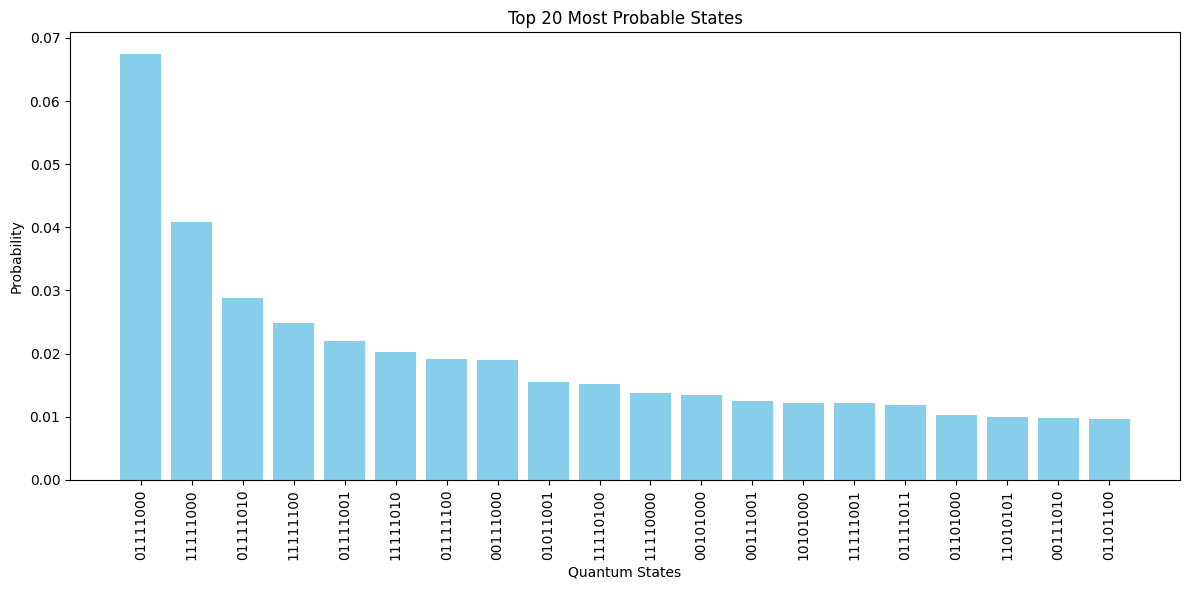

Estimator shots:  20000 
Samplere shots:  10000


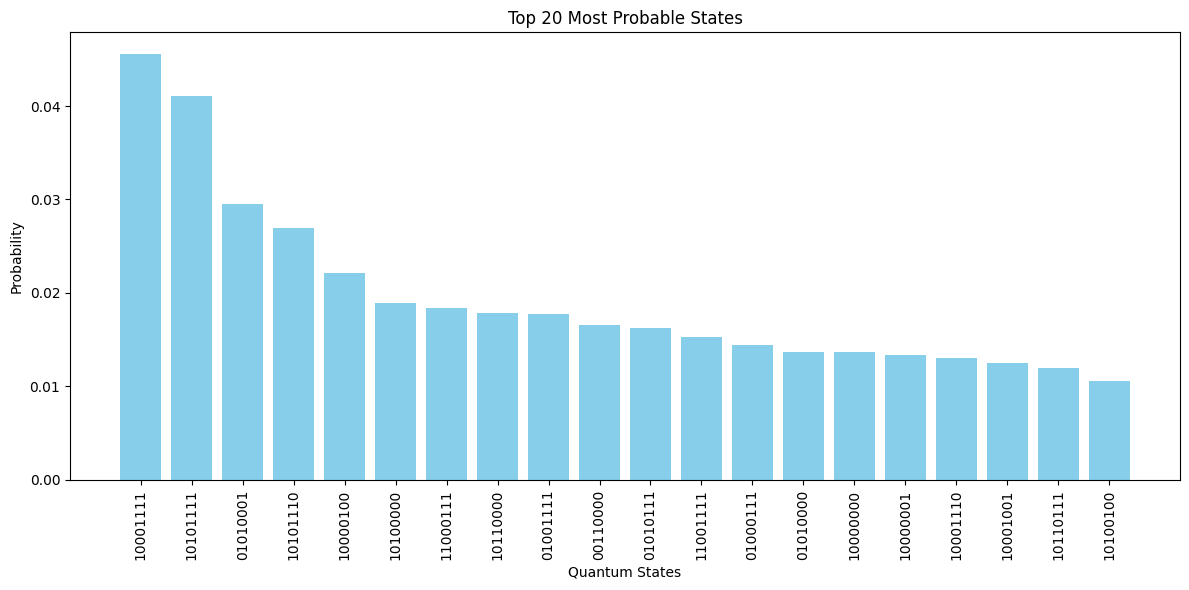

Estimator shots:  20000 
Samplere shots:  20000


KeyboardInterrupt: 

In [56]:
for i in range(10000, 50000, 10000):
    for j in range(10000, 50000, 10000):
        print("Estimator shots: ", i, "\nSamplere shots: ", j)
        run_experiment(10, 2, i, j, 3)

In [99]:
values = {'x1': 0, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 0}
qubo_problem.objective.evaluate([values[f'x{i}'] for i in range(1, 9)])

10000005.0

#### Using Performance Measures from Benchmarking the performance of portfolio optimization with QAOA

In [102]:
bestValues = {'x1': 1, 'x2': 1, 'x3': 0, 'x4': 0, 'x5': 1, 'x6': 0, 'x7': 1, 'x8': 0}
worstValuesFeasible = {'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 1, 'x6': 1, 'x7': 1, 'x8': 1}
worstValues = {'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 0, 'x6': 0, 'x7': 0, 'x8': 0}

fmax = qubo_problem.objective.evaluate([bestValues[f'x{i}'] for i in range(1, 9)])
fmin = qubo_problem.objective.evaluate([worstValuesFeasible[f'x{i}'] for i in range(1, 9)])
fmin2 = qubo_problem.objective.evaluate([worstValues[f'x{i}'] for i in range(1, 9)])

fmax, fmin, fmin2

(4.0, 8.0, 110000000.0)

In [103]:
def r(z):
    return (qubo_problem.objective.evaluate(z) - fmax) / (fmin - fmax)

In [104]:
r([bestValues[f'x{i}'] for i in range(1, 9)]), r([worstValuesFeasible[f'x{i}'] for i in range(1, 9)]), r([worstValues[f'x{i}'] for i in range(1, 9)])

(0.0, 1.0, 27499999.0)

In [137]:
def run_experiment_performance_measurement(n_range, p, shots_estimator, shots_sampler, level):
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=level)

    ansatz = QAOAAnsatz(hamiltonian, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    
    results_x = []
    for i in range(n_range):
        x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")
        results_x.append(res.x)
    results_x_mean = np.mean(results_x, axis=0)

    qc = ansatz.assign_parameters(results_x_mean)
    qc.measure_all()
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa]).result()
    variables = [list(map(int, key)) for key in result[0].data.meas.get_counts().keys()]

    approx_ratios = []
    for z in variables:
        approx_ratios.append(r(z))
    
    min_ratio = min(approx_ratios)
    min_ratio_z = variables[approx_ratios.index(min_ratio)]

    # Print the results
    print("Minimal approximation ratio:", min_ratio)
    print("Corresponding x array (z):", min_ratio_z)

In [146]:
run_experiment_performance_measurement(20, 4, 10, 10, 3)

Minimal approximation ratio: 1.0
Corresponding x array (z): [1, 1, 1, 1, 1, 1, 1, 1]
